# Purpose and Objectives:

Welcome! In this notebook, we will be covering the basics of autoencoder architectures, in particular the (vanilla) autoencoder and the variatonal autoencoder architectures. This notebook is intended to address the practical application side of these models. For more theoretical background, please refer to our notes on the topic.

After completing this notebook, you will:


1.   Have a complete understanding of the general AE and VAE architectures
2.   Be able to implemting AEs and VAEs in Pytorch
3.   Evaluate the models' performance (loss/accuracy), denoising ability, and latent space through visualizations



## Why Autoencoder Architectures? (Note to self: add images and figures later)

Autoencoder-style models have many different uses. We list several of the most notable ones here:

1.   **Dimensionality Reduction:** As mentioned in Hinton et. al., the main motivation for the AE architecutere is to turn "high-dimensional data" into "low dimensional codes". Adopting from the spirit of PCA, the encoder of an autoencoder can be thought of as a *nonlinear* map of the input data into the compressed space and the decoder an analogous yet opposite map that reconstructs the latent representation into the same dimensionality as the original input. Given sufficient data and computation, AEs can outperform PCA because AEs are not limited to learning a linear representation of the data. Datasets that feature high-dimensionality (e.g. biological/genetic data) can benefit from first applying AE dimensionality reduction before applying a later downstream task to the data. In this way, AE architectures can serve as a preprocessing step for other tasks.
2.   **Denoising:**
3.   **Data Generation:**
4.   **Anomaly Detection:**

In [1]:
import sklearn
from sklearn.manifold import TSNE

import torch
from torch import nn
from torch.distributions import MultivariateNormal, Normal, Independent

import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm

In [8]:
def mlp(in_dim, out_dim, hidden_dim, n_layers):
    layers = []
    layers.append(nn.Linear(in_dim, hidden_dim))
    layers.append(nn.ReLU())
    for _ in range(n_layers - 1):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden_dim, out_dim))
    return nn.Sequential(*layers)


In [11]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)
    
    def train_step(self, optimizer, x):
        z = self.encode(x)
        x_hat = self.decode(z)

        loss = self.loss(x, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss
    
    @staticmethod
    def loss(x, x_hat):
        return ((x - x_hat) ** 2).mean()

class VAE(nn.Module):
    def __init__(self, input_dimension=1*28*28, latent_dimension=10):
        super().__init__()
        self.z_mean = mlp(input_dimension, latent_dimension, 256, 4)
        self.z_log_std = mlp(input_dimension, latent_dimension, 256, 4)
        self.decoder = mlp(latent_dimension, input_dimension, 512, 4)
    
    def _encode(self, x):
        z_mean = self.z_mean(x)
        z_log_std = self.z_log_std(x)

        # reparameterization trick
        z_std = torch.exp(z_log_std)
        eps = torch.randn_like(z_std)
        z = z_mean + eps * z_std

        # log prob
        # 'd' not sampled on purpose
        # to show reparameterization trick
        d = Independent(Normal(z_mean, z_std), 1)
        log_prob = d.log_prob(z)

        return z_mean + eps * z_std, log_prob
    
    def encode(self, x):
        z, _ = self._encode(x)
        return z

    def decode(self, z):
        return self.decoder(z)
    
    def train_step(self, optimizer, x):
        z, log_prob = self._encode(x)
        x_hat = self.decode(z)

        loss = self.loss(x, x_hat, z, log_prob)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss

    @staticmethod
    def loss(x, x_hat, z, log_prob, kl_weight=0.0001):
        reconst_loss = ((x - x_hat) ** 2).mean()

        z_dim = z.shape[-1]
        standard_normal = MultivariateNormal(torch.zeros(z_dim), 
                                             torch.eye(z_dim))
        kld_loss = (log_prob - standard_normal.log_prob(z)).mean()
        
        return reconst_loss + kl_weight * kld_loss

In [12]:
# hyperparams
epochs = 5
lr = 1e-3
batch_size = 64

In [13]:
# data
train_dataset = datasets.MNIST(root='data/', download=True, transform=ToTensor())
test_dataset = datasets.MNIST(root='data/', train=False, transform=ToTensor())

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# model and optimizer
ae = VAE(latent_dimension=300)
optimizer = torch.optim.Adam(ae.parameters(), lr=lr)

# train
losses = []
step = 0
report_every = 100
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    for x, y in tqdm(train_dataloader):
        x = x.reshape(x.shape[0], -1)  # flatten
        loss = ae.train_step(optimizer, x)
        losses.append(loss.detach().numpy())
        step += 1
        if step % report_every == 0:
          print(f"Training loss: {loss}")

Epoch 1


 11%|█         | 103/938 [00:05<00:45, 18.15it/s]

Training loss: 0.06356911361217499


 21%|██▏       | 201/938 [00:11<00:52, 13.91it/s]

Training loss: 0.059518009424209595


 32%|███▏      | 301/938 [00:18<01:21,  7.86it/s]

Training loss: 0.05585183575749397


 43%|████▎     | 402/938 [00:23<00:37, 14.29it/s]

Training loss: 0.057764068245887756


 54%|█████▎    | 502/938 [00:30<00:23, 18.90it/s]

Training loss: 0.05336968973278999


 64%|██████▍   | 602/938 [00:35<00:20, 16.11it/s]

Training loss: 0.04882071539759636


 75%|███████▍  | 701/938 [00:44<00:19, 11.90it/s]

Training loss: 0.045554351061582565


 85%|████████▌ | 801/938 [00:55<00:11, 11.83it/s]

Training loss: 0.04258151352405548


 96%|█████████▌| 901/938 [01:03<00:04,  9.23it/s]

Training loss: 0.04130598157644272


100%|██████████| 938/938 [01:07<00:00, 13.99it/s]


Epoch 2


  7%|▋         | 62/938 [00:09<03:37,  4.02it/s]

Training loss: 0.040484264492988586


 17%|█▋        | 164/938 [00:19<01:03, 12.27it/s]

Training loss: 0.042488954961299896


 28%|██▊       | 264/938 [00:28<00:55, 12.17it/s]

Training loss: 0.03884953260421753


 39%|███▉      | 364/938 [00:37<00:52, 11.01it/s]

Training loss: 0.036392245441675186


 49%|████▉     | 464/938 [00:45<00:40, 11.69it/s]

Training loss: 0.03815016523003578


 60%|██████    | 564/938 [00:55<00:32, 11.56it/s]

Training loss: 0.037899211049079895


 71%|███████   | 664/938 [01:04<00:23, 11.74it/s]

Training loss: 0.035549331456422806


 81%|████████▏ | 763/938 [01:13<00:18,  9.46it/s]

Training loss: 0.03552931919693947


 92%|█████████▏| 863/938 [01:22<00:06, 11.70it/s]

Training loss: 0.03509575128555298


100%|██████████| 938/938 [01:29<00:00, 10.50it/s]


Epoch 3


  3%|▎         | 26/938 [00:02<01:16, 11.96it/s]

Training loss: 0.036545317620038986


 13%|█▎        | 125/938 [00:11<01:34,  8.57it/s]

Training loss: 0.03380398824810982


 24%|██▍       | 224/938 [00:19<01:28,  8.06it/s]

Training loss: 0.03134447708725929


 35%|███▍      | 325/938 [00:30<00:52, 11.60it/s]

Training loss: 0.03396202251315117


 45%|████▌     | 425/938 [00:43<00:44, 11.49it/s]

Training loss: 0.034622080624103546


 56%|█████▌    | 525/938 [00:52<00:35, 11.63it/s]

Training loss: 0.03626050800085068


 67%|██████▋   | 625/938 [01:03<01:21,  3.86it/s]

Training loss: 0.03188053518533707


 77%|███████▋  | 725/938 [01:14<00:23,  9.13it/s]

Training loss: 0.032075121998786926


 88%|████████▊ | 825/938 [01:23<00:09, 11.62it/s]

Training loss: 0.03191957250237465


 99%|█████████▊| 925/938 [01:33<00:01,  7.92it/s]

Training loss: 0.03146664425730705


100%|██████████| 938/938 [01:35<00:00,  9.86it/s]


Epoch 4


  9%|▉         | 86/938 [00:09<01:23, 10.15it/s]

Training loss: 0.0333864726126194


 20%|█▉        | 187/938 [00:21<01:26,  8.68it/s]

Training loss: 0.030307870358228683


 31%|███       | 287/938 [00:30<01:04, 10.06it/s]

Training loss: 0.03161630034446716


 41%|████▏     | 387/938 [00:39<00:46, 11.77it/s]

Training loss: 0.028603432700037956


 52%|█████▏    | 487/938 [00:49<00:38, 11.58it/s]

Training loss: 0.03061007894575596


 63%|██████▎   | 587/938 [00:58<01:03,  5.53it/s]

Training loss: 0.031715210527181625


 73%|███████▎  | 688/938 [01:07<00:21, 11.63it/s]

Training loss: 0.030426299199461937


 84%|████████▍ | 788/938 [01:17<00:12, 11.74it/s]

Training loss: 0.029380569234490395


 95%|█████████▍| 888/938 [01:26<00:04, 11.64it/s]

Training loss: 0.03056970238685608


100%|██████████| 938/938 [01:31<00:00, 10.28it/s]


Epoch 5


  5%|▌         | 48/938 [00:04<02:59,  4.96it/s]

Training loss: 0.028948834165930748


 16%|█▌        | 150/938 [00:15<01:06, 11.91it/s]

Training loss: 0.027747396379709244


 27%|██▋       | 249/938 [00:26<00:59, 11.62it/s]

Training loss: 0.031216377392411232


 37%|███▋      | 350/938 [00:35<00:50, 11.54it/s]

Training loss: 0.029874064028263092


 48%|████▊     | 449/938 [00:44<00:57,  8.51it/s]

Training loss: 0.03199920430779457


 59%|█████▊    | 549/938 [00:54<00:42,  9.25it/s]

Training loss: 0.030300471931695938


 69%|██████▉   | 650/938 [01:04<00:24, 11.93it/s]

Training loss: 0.028235487639904022


 80%|███████▉  | 749/938 [01:13<00:16, 11.42it/s]

Training loss: 0.03022843971848488


 91%|█████████ | 849/938 [01:24<00:09,  9.10it/s]

Training loss: 0.027067331597208977


100%|██████████| 938/938 [01:32<00:00, 10.16it/s]


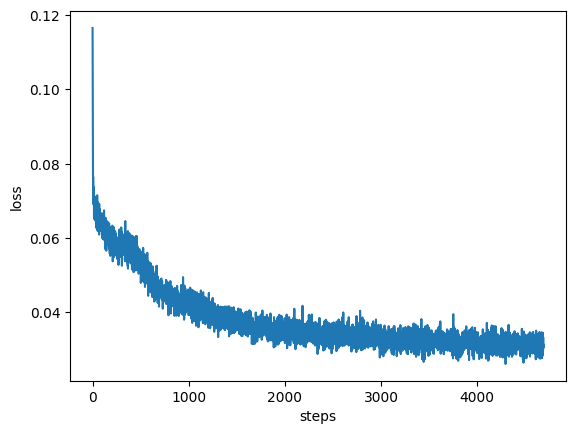

In [ ]:
# training logs
plt.plot(losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

In [ ]:
# analysis
num_samples = 512

viz_dataloader = DataLoader(test_dataset, batch_size=num_samples, shuffle=True)

x, y = next(iter(viz_dataloader))
x = x.reshape(x.shape[0], -1)
z = ae.encode(x)
z = z.detach().numpy()

tsne = TSNE()
z = tsne.fit_transform(z)

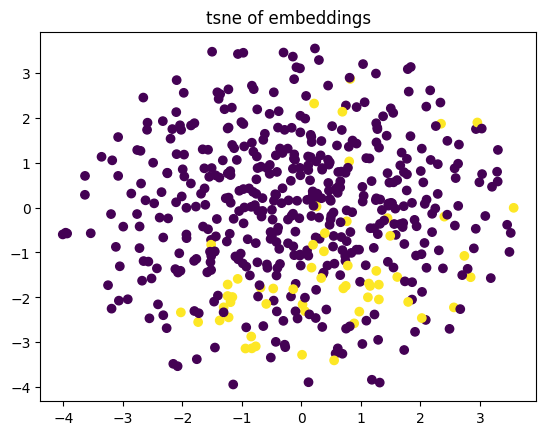

In [ ]:
viz_label = 0
plt.scatter(z[:, 0], z[:, 1], c=(y==viz_label))
plt.title('tsne of embeddings')
plt.show()

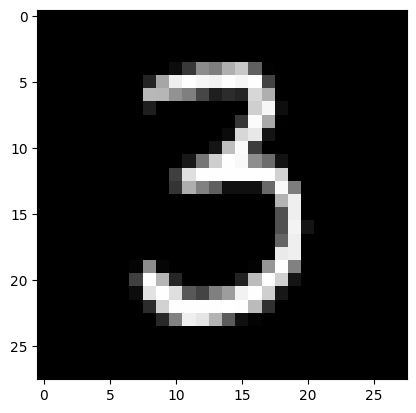

In [ ]:
plt.imshow(train_dataset[50][0].reshape(28, 28), cmap='gray')

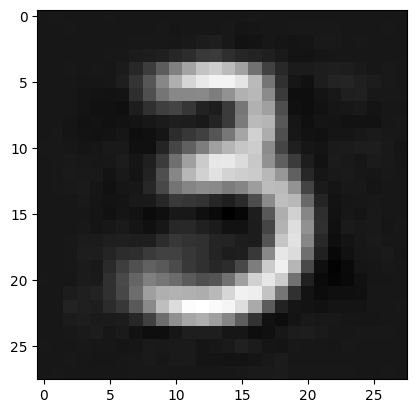

In [ ]:
encoded = ae.encode(train_dataset[50][0].flatten())
decoded = ae.decode(encoded)
plt.imshow(decoded.detach().numpy().reshape(28, 28), cmap='gray')

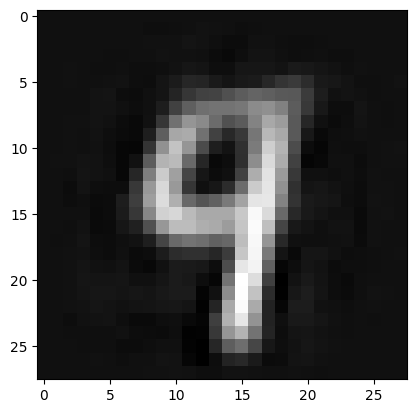

In [ ]:
import numpy as np
random_z = torch.normal(torch.zeros(300))
decoded = ae.decode(random_z.float())
plt.imshow(decoded.detach().numpy().reshape(28, 28), cmap='gray')

citations:
* https://github.com/AntixK/PyTorch-VAE
* 182 hw7

